In [1]:
!pwd

/home/alma.andersson/eggplant/notebooks


In [2]:
%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt
import scanpy as sc
from scipy.spatial.distance import cdist

import anndata as ad
import pandas as pd
import sys

import eggplant as eg

    
import os.path as osp
import os
from PIL import Image

In [3]:
MAIN_DIR = "/data/alma.andersson/eggplant/data"
CNT_PTHS = ["developmental-heart/w_10/anndata/V10F24-105_A1.h5ad",
            "developmental-heart/w_10/anndata/V10F24-105_B1.h5ad",
            "developmental-heart/w_10/anndata/V10F24-105_C1.h5ad",
            "developmental-heart/w_10/anndata/V10F24-105_D1.h5ad",
           ]
CNT_PTHS = [osp.join(MAIN_DIR,p) for p in CNT_PTHS]

In [4]:
REF_DIR = "/home/alma/w-projects/ccf/rsc/ref/dev-heart"
REF_DIR = "/data/alma.andersson/eggplant/references/w_10/dev-heart"

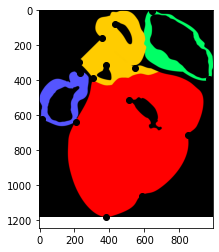

In [5]:
ref_img = Image.open(osp.join(REF_DIR,"dev-heart-black-002.png"))
ref_lmk = pd.read_csv(osp.join(REF_DIR,"dev-heart_landmarks.tsv"),sep="\t",header = 0,index_col=0)

plt.imshow(ref_img)
plt.scatter(ref_lmk.x_coord,ref_lmk.y_coord,c = "black")


In [6]:
grid_crd,mta = eg.pp.reference_to_grid(ref_img,
                                       n_approx_points=10000,
                                       n_regions=4,
                                       background_color = "black",
                                      )

In [7]:
n_lmk = ref_lmk.shape[0]
lmk_cmap = {0:"blue",1:"red",2:"green",3:"yellow",4:"magenta"}

In [8]:
mta_cmap = {0:"#D40000",1:"#44AA00",2:"#2D70D2",3:"#54C4FF"}

In [9]:
n_lmk

15

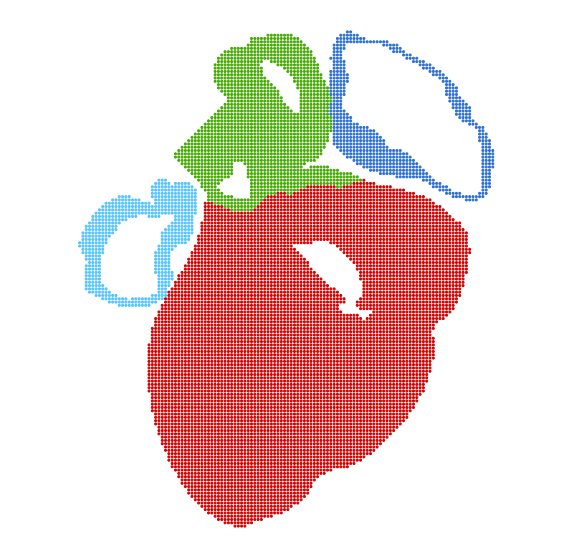

In [10]:
plt.figure(figsize=(10,10),facecolor ="white")
plt.scatter(grid_crd[:,0],
            grid_crd[:,1],
            c = [mta_cmap[x] for x in mta],s = 4)

plt.axis("equal")
plt.axis("off")
#for ii in range(n_lmk):
#    plt.scatter(ref_lmk.x_coord.values[ii],
#                ref_lmk.y_coord.values[ii],
#                c = lmk_cmap[ii % len(lmk_cmap)],
#                marker = "*",
#                edgecolor ="black",
#                s = 250,
#               )

plt.gca().invert_yaxis()
plt.show()

In [11]:
!export CUDA_VISIBLE_DEVICES=0 

In [12]:
ref = eg.m.Reference(grid_crd,
                     landmarks = ref_lmk.values,
                      meta = dict(region = mta),
                    )

/home/alma.andersson/miniconda3/lib/python3.8/site-packages/anndata-0.7.5-py3.8.egg/anndata/_core/anndata.py:119: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


In [13]:
adatas = [ad.read_h5ad(p) for p in CNT_PTHS]


Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.


In [14]:
for a in adatas:
    print(a)

AnnData object with n_obs × n_vars = 2169 × 33538
    obs: 'in_tissue', 'array_row', 'array_col'
    var: 'gene_ids', 'feature_types', 'genome'
    uns: 'curated_landmarks', 'spatial'
    obsm: 'spatial'
AnnData object with n_obs × n_vars = 2246 × 33538
    obs: 'in_tissue', 'array_row', 'array_col'
    var: 'gene_ids', 'feature_types', 'genome'
    uns: 'curated_landmarks', 'spatial'
    obsm: 'spatial'
AnnData object with n_obs × n_vars = 2250 × 33538
    obs: 'in_tissue', 'array_row', 'array_col'
    var: 'gene_ids', 'feature_types', 'genome'
    uns: 'curated_landmarks', 'spatial'
    obsm: 'spatial'
AnnData object with n_obs × n_vars = 2513 × 33538
    obs: 'in_tissue', 'array_row', 'array_col'
    var: 'gene_ids', 'feature_types', 'genome'
    uns: 'curated_landmarks', 'spatial'
    obsm: 'spatial'


In [15]:
adatas = {f"dh{l}":adatas[k] for k,l in enumerate(["A","B","C","D"])}#,"dhB":adatas[1]}

In [16]:
columns = ["x_coord","y_coord"]
for key in adatas.keys():
    n_lmk_a = adatas[key].uns["curated_landmarks"].shape[0]
    index = [f"L{k}" for k in range(n_lmk_a)]
    adatas[key].uns["curated_landmarks"] = pd.DataFrame(adatas[key].uns["curated_landmarks"],
                                                       columns = columns,
                                                        index = index,
                                                       )

In [17]:
for adata in adatas.values():
    # standard normalization steps
    sc.pp.filter_genes(adata,
                       min_cells = 0.1)
    
    sc.pp.normalize_total(adata,1e4,
                          exclude_highly_expressed = True)
    sc.pp.log1p(adata)
    sc.pp.scale(adata)
    #--- eggplant specific pre-processing---
    # match scales
    eg.pp.match_scales(adata,ref)
    # perform TPS warping and calculate landmark distances
    eg.pp.get_landmark_distance(adata,
                                reference=ref)



/home/alma.andersson/miniconda3/envs/eggplant/lib/python3.8/site-packages/pandas-1.3.1-py3.8-linux-x86_64.egg/pandas/core/arrays/categorical.py:2630: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.


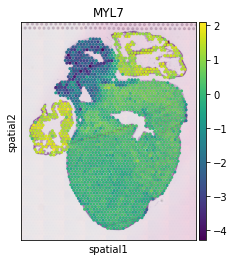

In [18]:
sc.pl.spatial(adatas["dhA"],color ="MYL7",size=0.4e-4)

In [19]:
ref.clean()

In [20]:
np.random.seed(1337)
genes = ["MYH6","ELN","MYH7","MYL7","COL2A1"]
idx = np.random.choice(len(adatas["dhA"]),
                       replace = False,
                       size = 1500)

losses = eg.fun.transfer_to_reference(adatas,
                                      genes,
                                      ref,
                                      n_epochs=1000,
                                      device ="gpu",
                                      verbose = True,
                                      return_losses = True,
                                      return_models =False,
                                      max_cg_iterations = 10000,
                                      )

[Processing] ::  Model : dhA | Feature : MYH6 | Transfer : 1/20


  0%|                          | 0/1000 [00:00<?, ?it/s]/home/alma.andersson/miniconda3/envs/eggplant/lib/python3.8/site-packages/gpytorch-1.5.0-py3.8.egg/gpytorch/utils/linear_cg.py:234: UserWarning: An output with one or more elements was resized since it had shape [11], which does not match the required output shape [1, 11].This behavior is deprecated, and in a future PyTorch release outputs will not be resized unless they have zero elements. You can explicitly reuse an out tensor t by resizing it, inplace, to zero elements with t.resize_(0). (Triggered internally at  /pytorch/aten/src/ATen/native/Resize.cpp:23.)
  torch.sum(mul_storage, -2, keepdim=True, out=alpha)
100%|███████████████| 1000/1000 [00:35<00:00, 28.44it/s]


[Processing] ::  Model : dhA | Feature : ELN | Transfer : 2/20


100%|███████████████| 1000/1000 [00:35<00:00, 28.05it/s]


[Processing] ::  Model : dhA | Feature : MYH7 | Transfer : 3/20


100%|███████████████| 1000/1000 [00:35<00:00, 28.04it/s]


[Processing] ::  Model : dhA | Feature : MYL7 | Transfer : 4/20


100%|███████████████| 1000/1000 [00:35<00:00, 28.10it/s]


[Processing] ::  Model : dhA | Feature : COL2A1 | Transfer : 5/20


100%|███████████████| 1000/1000 [00:35<00:00, 28.03it/s]


[Processing] ::  Model : dhB | Feature : MYH6 | Transfer : 6/20


100%|███████████████| 1000/1000 [00:35<00:00, 28.28it/s]


[Processing] ::  Model : dhB | Feature : ELN | Transfer : 7/20


100%|███████████████| 1000/1000 [00:35<00:00, 27.92it/s]


[Processing] ::  Model : dhB | Feature : MYH7 | Transfer : 8/20


100%|███████████████| 1000/1000 [00:31<00:00, 31.26it/s]


[Processing] ::  Model : dhB | Feature : MYL7 | Transfer : 9/20


100%|███████████████| 1000/1000 [00:31<00:00, 31.30it/s]


[Processing] ::  Model : dhB | Feature : COL2A1 | Transfer : 10/20


100%|███████████████| 1000/1000 [00:35<00:00, 27.90it/s]


[Processing] ::  Model : dhC | Feature : MYH6 | Transfer : 11/20


100%|███████████████| 1000/1000 [00:35<00:00, 28.19it/s]


[Processing] ::  Model : dhC | Feature : ELN | Transfer : 12/20


100%|███████████████| 1000/1000 [00:35<00:00, 28.34it/s]


[Processing] ::  Model : dhC | Feature : MYH7 | Transfer : 13/20


100%|███████████████| 1000/1000 [00:32<00:00, 30.70it/s]


[Processing] ::  Model : dhC | Feature : MYL7 | Transfer : 14/20


100%|███████████████| 1000/1000 [00:36<00:00, 27.75it/s]


[Processing] ::  Model : dhC | Feature : COL2A1 | Transfer : 15/20


100%|███████████████| 1000/1000 [00:35<00:00, 28.47it/s]


[Processing] ::  Model : dhD | Feature : MYH6 | Transfer : 16/20


100%|███████████████| 1000/1000 [00:35<00:00, 28.17it/s]


[Processing] ::  Model : dhD | Feature : ELN | Transfer : 17/20


100%|███████████████| 1000/1000 [00:35<00:00, 28.51it/s]


[Processing] ::  Model : dhD | Feature : MYH7 | Transfer : 18/20


100%|███████████████| 1000/1000 [00:34<00:00, 28.61it/s]


[Processing] ::  Model : dhD | Feature : MYL7 | Transfer : 19/20


100%|███████████████| 1000/1000 [00:33<00:00, 29.91it/s]


[Processing] ::  Model : dhD | Feature : COL2A1 | Transfer : 20/20


100%|███████████████| 1000/1000 [00:38<00:00, 25.71it/s]


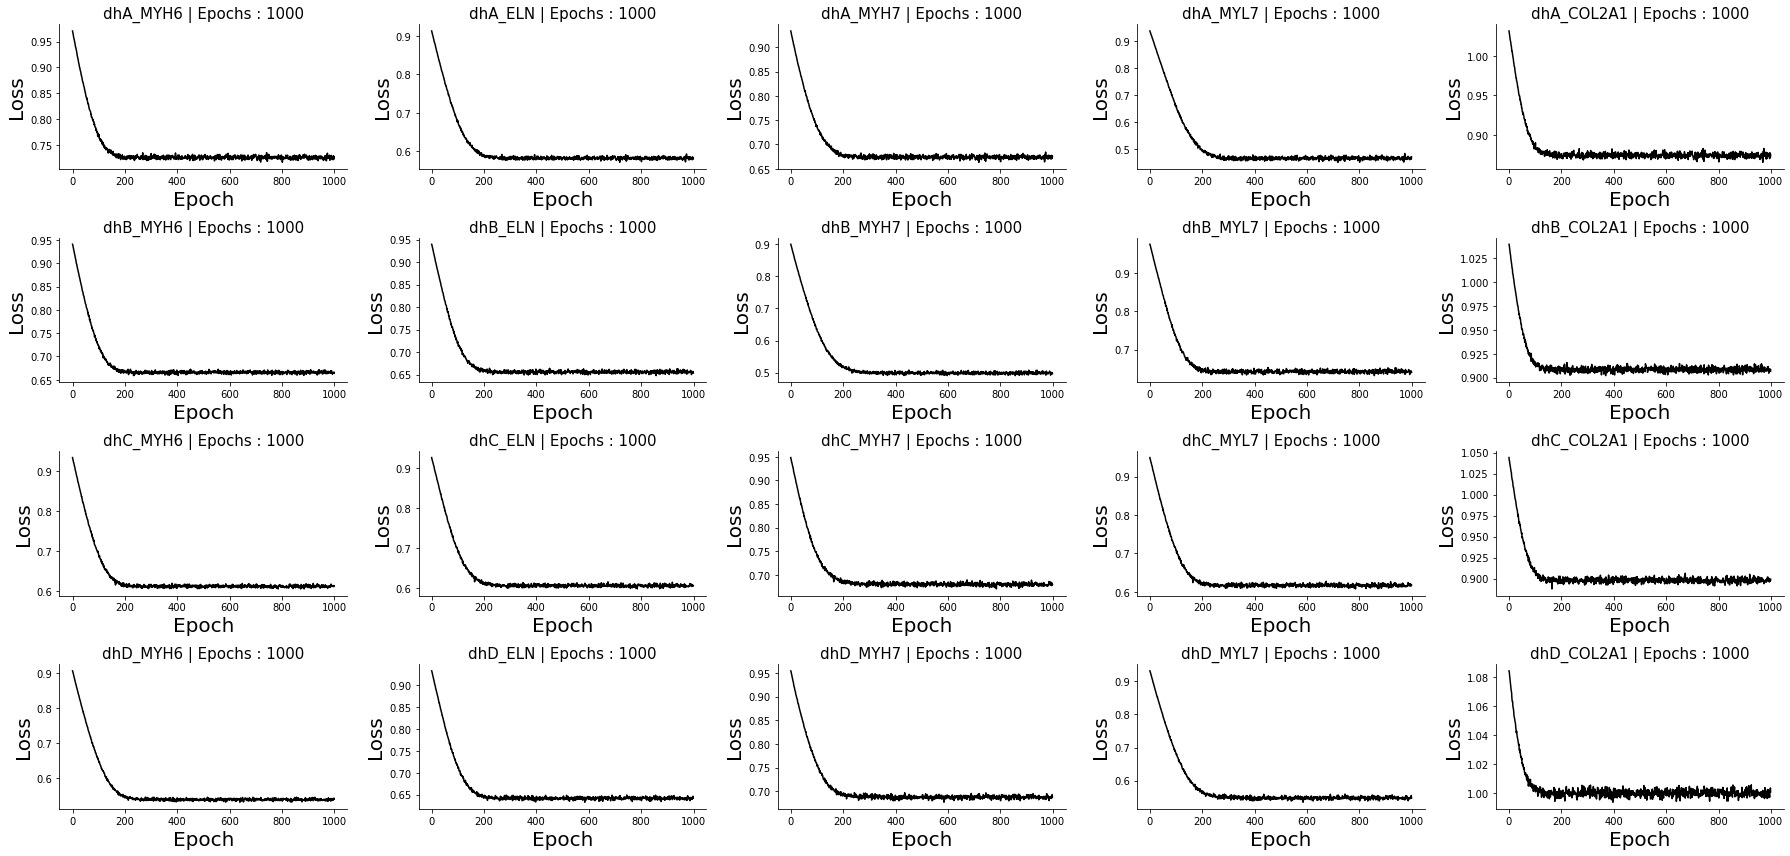

In [21]:
eg.pl.model_diagnostics(losses = losses)

In [22]:
import copy
ref2 = copy.deepcopy(ref)

In [23]:
feats = ref2.adata.var["feature"].values
uni_feat = np.unique(feats)
new_X = np.zeros((len(ref2.adata),len(uni_feat)))
for k,f in enumerate(uni_feat):
    new_X[:,k] = ref.adata.X[:,feats == f].mean(axis=1)
    
new_var = pd.DataFrame(uni_feat,
                       index = ["Average {}".format(x) for x in uni_feat],
                       columns = ["feature"],
                      )
new_adata = ad.AnnData(new_X,
                       var = new_var,
                       obs = ref2.adata.obs,
                      )

ref2.adata = new_adata

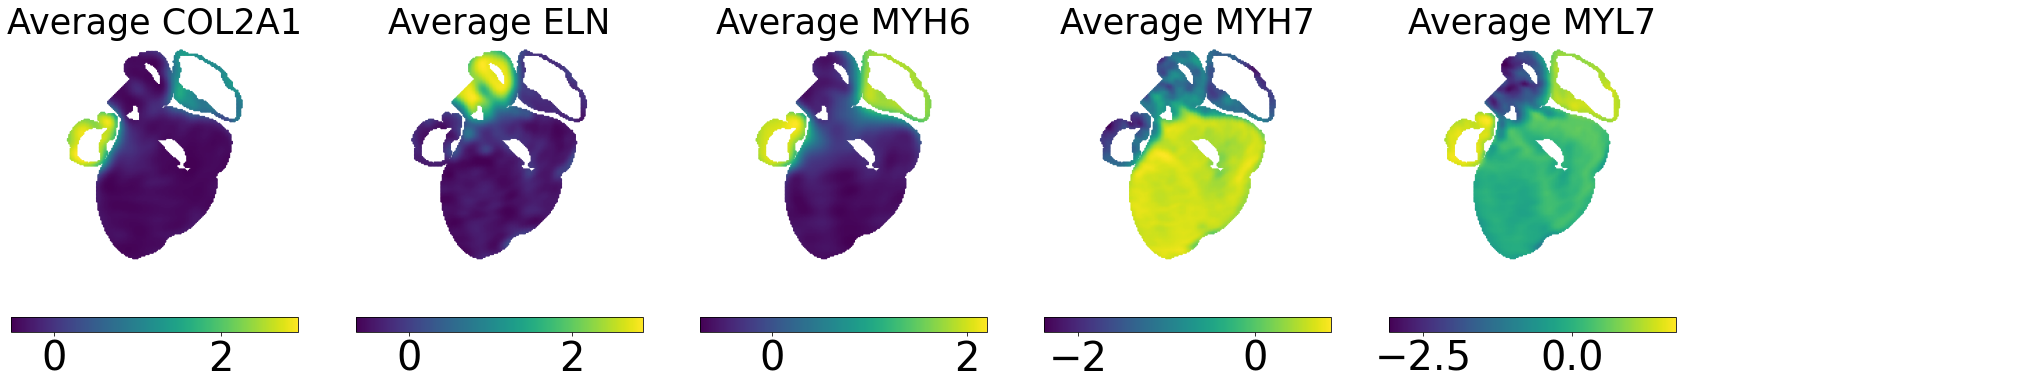

In [24]:
eg.pl.visualize_transfer(ref2,
                         n_cols = 6,
                         side_size = 6,
                         quantile_scaling = False,
                         flip_y = True,
                         show_landmarks = False,
                         marker_size = 2,
                         include_colorbar = True,
                         separate_colorbar = False,
                         share_colorscale = False,
                         fontsize = 35,
                         colorbar_fontsize = 40,
                        )

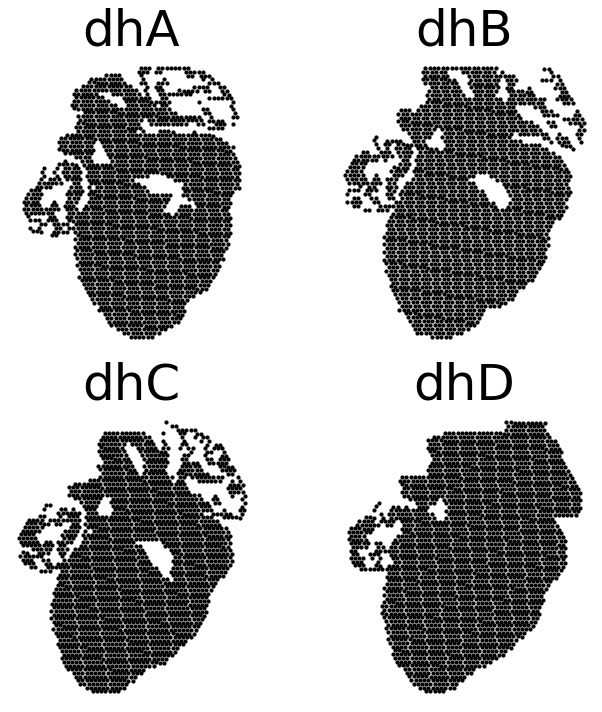

In [25]:
fig,ax = plt.subplots(2,2,figsize = (10,10))
ax = ax.flatten()
for k,(name,_adata) in enumerate(adatas.items()):
    ax[k].scatter(_adata.obsm["spatial"][:,0],
                  _adata.obsm["spatial"][:,1],
                  s = 10,
                  marker = "o",
                  #c = _adata.obs_vector("MYH10"),
                  c = "black",
                 )
    ax[k].axis("off")
    ax[k].set_title(name,fontsize = 50)
    ax[k].invert_yaxis()
    ax[k].set_aspect("equal")
    
fig.tight_layout()
    
    

In [26]:
import matplotlib

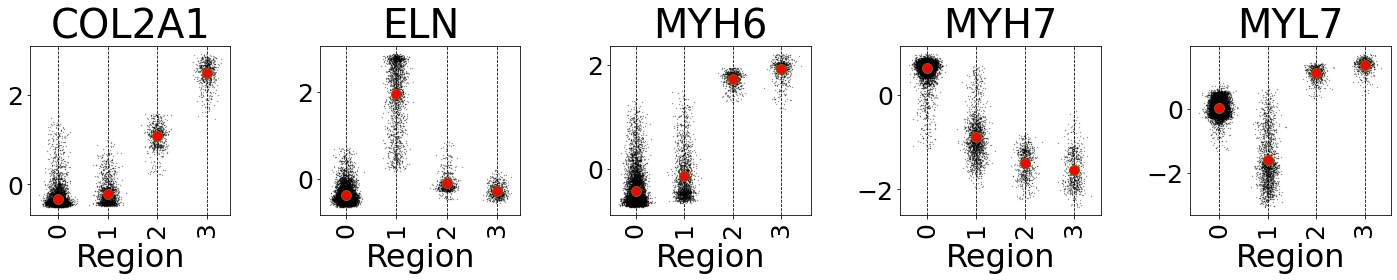

In [27]:
outside = {"attribute":"var","column":"feature"}
inside = {"attribute":"obs","column":"region"}
fig,ax = eg.pl.swarmplot_transfer(ref,
                       inside,
                       outside,
                       return_figure=True,
                       n_cols = 5,
                        ticks_fontsize = 25,
                                  title_fontsize = 40,
                        mean_marker_style={"c":"red","s":100,"marker":"o"}
                    )

for k,axx in enumerate(ax):
    axx.set_ylabel("")
    axx.set_xlabel("Region")#,fontsize = )


### Statistical Test of COL2A1 left-right asymmetry

In [29]:
from scipy.stats import normaltest, mannwhitneyu

In [30]:
is_x = ref.adata.var.feature.values == "COL2A1"
is_r2 = ref.adata.obs.region.values == 2
is_r3 = ref.adata.obs.region.values == 3

x_r2 = ref.adata.X[is_r2,:][:,is_x].flatten()
x_r3 = ref.adata.X[is_r3,:][:,is_x].flatten()

alpha = 0.01
nt_r2 = normaltest(x_r2).pvalue
nt_r3 = normaltest(x_r3).pvalue

report_string = "Expression in Region {} {} be considered normal"
if nt_r2 < alpha:
    print(report_string.format(2,"cannot"))
else:
    print(report_string.format(2,"can"))
if nt_r3 < alpha:
    print(report_string.format(3,"cannot"))
else:
    print(report_string.format(3,"can"))

Expression in Region 2 cannot be considered normal
Expression in Region 3 cannot be considered normal


In [36]:
test_res = mannwhitneyu(x_r3,x_r2,alternative = "two-sided")
pval = test_res.pvalue
if pval < alpha:
    print("Significant difference between regions. p-value = {}".format(pval))
else:
    print("No significant difference between regions. p-value = {}".format(pval))

Significant difference between regions. p-value = 0.0
